In [71]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint
        
def restrict01( input ):
    return np.maximum( np.minimum(input,1) , 0 )

def nonneg( input ):
    return np.maximum(input,0); 

class Tumor: 
    def __init__( self, timesteps=100 ): 
        self.steps = timesteps; 
        self.Cdead = np.zeros( (self.steps,) ); 
        self.C = np.zeros( (self.steps,) );  
        self.C[0] = 10;   
        self.birth = 4.168e-3 / 24.0; 
        self.death = 0.1 * self.birth # 0.01 * self.birth; 
        self.max_death = 4.168e-3 / 24; 
        self.dead_clearance = 0.001 ; 
        self.O2_use = 0.04168
        self.O2_S = 38; 
        self.O2_HP = 5; 
        self.O2_HD = 8; 
        self.O2_HR = 10;
        # Met Variables 
        self.MET_1 = np.zeros( (self.steps,) )
        self.MET_2 = np.zeros( (self.steps,) )
        self.MET_3 = np.zeros( (self.steps,) )
        self.MET_O = np.zeros( (self.steps,) )

        self.fCM_1 = 0.0343
        self.fCM_2 = 0.0321
        self.fCM_3 = 0.0284
        self.fCM_O = 0.0052
        self.rM = self.birth
        #Circulation Variables TODO See if they screw up the function
        self.CIRC = np.zeros( (self.steps,) );
        self.fPC = 0.1
        self.rPC = 0.002
        self.dC = 0.1
        self.rCM = 0.15
        
    def resize( self, newsteps): 
        self.steps = newsteps;
        self.Cdead = np.zeros( (self.steps,) ); 
        self.C = np.zeros( (self.steps,) );  
        self.C[0] = 1;  

In [72]:
class Environment:
    def __init__( self, timesteps=100 ):
        self.steps = timesteps; 
        self.O2_blood = 80; 
        self.rS = 1e2;
        self.O2 = self.O2_blood * np.ones( (self.steps,) ); 
        self.P = np.zeros( self.steps ); 
        self.A = np.zeros( self.steps ) ;
        
        self.P_decay = 6e-2; 
        self.A_decay = 1e-2; # 1e-1

        # Vascularization (B) variables
        self.B = np.ones( (self.steps,) );
        self.rB = 0.005

        # VEGF variables
        self.VEGF = np.zeros( (self.steps,) );
        self.VEGF_max = 4.4e-5
        self.VEGF_decay = 0.01

    def resize( self, newsteps ): 
        self.steps = newsteps; 
        self.O2 = np.zeros( (self.steps,) );    
        self.P = np.zeros( self.steps ); 
        self.A = np.zeros( self.steps ) ;

In [73]:
class Simulation:
    def __init__( self , tmax = 24*30 , dt = 0.01 ):
        self.dt = dt;
        self.units = "hours"; 
        self.T = np.arange( 0, tmax+0.01*dt , dt ); 
        self.steps = len( self.T ); 
        
        self.E = Environment( self.steps ); 
        self.IS = ImmuneSystem( self.steps ); 
        self.Tumor = Tumor( self.steps ); 

    def run_model( self ):
        # order: (O2,P,A,C,Cdead)
        # make initial condition 
        Y0 = [ self.E.O2[0] , self.E.P[0] , self.E.A[0], 
              self.Tumor.C[0] , self.Tumor.Cdead[0] , 
              self.IS.M0[0] , self.IS.M1[0], self.IS.M2[0] , 
              self.IS.D[0] , self.IS.CTL[0], self.IS.Treg[0],
              self.Tumor.MET_1[0], self.Tumor.MET_2[0], self.Tumor.MET_3[0], self.Tumor.MET_O[0], 
              self.Tumor.CIRC[0], self.E.VEGF[0], self.E.B[0]]
        # run the model 
        Y = odeint( model, Y0, self.T ); 
        # write data to correct places 
        self.E.O2 = Y[:,0]; 
        self.E.P = Y[:,1]; 
        self.E.A = Y[:,2]; 
        self.Tumor.C = Y[:,3]; 
        self.Tumor.Cdead = Y[:,4]; 
        self.IS.M0 = Y[:,5]; 
        self.IS.M1 = Y[:,6]; 
        self.IS.M2 = Y[:,7]; 
        self.IS.D = Y[:,8];
        self.IS.CTL = Y[:,9]; 
        self.IS.Treg = Y[:,10]; 
        self.Tumor.MET_1 = Y[:,11]; 
        self.Tumor.MET_2 = Y[:,12]; 
        self.Tumor.MET_3 = Y[:,13]; 
        self.Tumor.MET_O = Y[:,14];
        self.Tumor.CIRC = Y[:,15];
        self.E.VEGF = Y[:,16];
        self.E.B = Y[:,17];
     

In [74]:
def setup_plot( fignum = 1 ):
    plt.figure(fignum)
    plt.clf(); 
    plt.gcf().set_size_inches(10,10)
    plt.grid(True,which="both", linestyle='--')
    
def trim( input , tol=0.5 ):
    return np.maximum( input , tol ); 
        
def plot( Sim , filebase ):
    T = Sim.T / (24*30); 
    setup_plot(1); 
    plt.figure(1); 
    plt.plot( T , Sim.E.O2 / Sim.E.O2_blood );
    plt.plot( T , Sim.E.P ); 
    plt.plot( T , Sim.E.A ); 
    plt.plot(T, Sim.E.VEGF )
    plt.plot(T, Sim.E.B)
    plt.legend( ['O2 / O2_blood', 'Pro-Inf' , 'Anti-Inf' , "VEGF", "Vascul."] ); 
    plt.xlabel('t (months)' ); 
    filename = filebase + "_env_1yr.jpg"; 
    plt.title("O2 and Signal Environment")
    plt.savefig(filename) 

    setup_plot(2); 
    plt.figure(2); 
    plt.plot( T , trim(Sim.Tumor.C) , T, trim(Sim.Tumor.MET_1), T, trim(Sim.Tumor.MET_2), T, trim(Sim.Tumor.MET_3), T, trim(Sim.Tumor.MET_O), T, trim(Sim.Tumor.Cdead))
    plt.xlabel('t (months)' ); 
    plt.legend( ['Primary Tumor cells', "Bone Met cells", "Lung Met cells", "Brain Met cells", "Other Met cells", 'Dead Primary cells'] ); 
    filename = filebase + "_tumor_2yr.jpg"; 
    plt.title("Primary and Metastatic Tumor Growth")
    plt.hlines(12500, T[0], T[len(T)-1], linestyles="dotted", color = "black", label="Detectable Size")
    plt.savefig(filename) 
    
    setup_plot(3); 
    plt.figure(3); 
    plt.semilogy( T , trim(Sim.Tumor.C) , T, trim(Sim.Tumor.MET_1), T, trim(Sim.Tumor.MET_2), T, trim(Sim.Tumor.MET_3), T, trim(Sim.Tumor.MET_O), T, trim(Sim.Tumor.Cdead))
    plt.xlabel('t (months)' ); 
    plt.legend( ['Primary Tumor cells', "Bone Met cells", "Lung Met cells", "Brain Met cells", "Other Met cells", 'Dead Primary cells'] ); 
    filename = filebase + "_log_tumor_1yr.jpg"; 
    plt.title("(Log) Primary and Metastatic Tumor Growth")
    plt.savefig(filename)   

    setup_plot(4); 
    plt.figure(4); 
    plt.semilogy(T, trim(Sim.Tumor.MET_1), T, trim(Sim.Tumor.MET_2), T, trim(Sim.Tumor.MET_3), T, trim(Sim.Tumor.MET_O))
    plt.xlabel('t (months)' ); 
    plt.legend( ["Bone Met cells", "Lung Met cells", "Brain Met cells", "Other Met cells"] ); 
    filename = filebase + "_log_mets_1yr.jpg"; 
    plt.title("(Log) Primary and Metastatic Tumor Growth")
    plt.savefig(filename)   

    setup_plot(5); 
    plt.figure(5); 
    plt.semilogy( T,trim(Sim.IS.M0) , T,trim(Sim.IS.M1) , T,trim(Sim.IS.M2) )
    M = Sim.IS.M0 + Sim.IS.M1 + Sim.IS.M2 + 1e-5 
    plt.semilogy( T,trim(M))
    
    plt.semilogy( T,trim(Sim.IS.D) , T,trim(Sim.IS.CTL) , T,trim(Sim.IS.Treg) )
    plt.xlabel('t (months)' ); 
    plt.legend( ['M0 M$\Phi$s', 'M1 M$\Phi$s', 'M2 M$\Phi$s',
                 'Total M$\Phi$s','Dendritic cells','CTLs','Tregs'], 
              loc='lower right'); 
    # plt.yscale('linear')
    filename = filebase + "_immune_1yr.jpg";
    plt.title("Immune Environment") 
    plt.savefig(filename)   
    
    setup_plot(6); 
    plt.figure(6); 
    # plt.stackplot( Sim.T, 100* Sim.IS.M0/M,100*Sim.IS.M1/M , 100*Sim.IS.M2/M )
    plt.stackplot( T, 100* Sim.IS.M0/M,100*Sim.IS.M1/M , 100*Sim.IS.M2/M )
    # plt.xlabel('t (' + Sim.units + ')' ); 
    plt.xlabel('t (months)' ); 
    plt.legend( ['% M0 M$\Phi$s', '% M1 M$\Phi$s', '% M2 M$\Phi$s'], 
              loc='lower right'); 
    filename = filebase + "_macrophages_1yr.jpg"; 
    plt.title("Macrophage Cycling") 
    plt.savefig(filename)      
    
     
            

In [75]:
class ImmuneSystem: 
    def __init__( self, timesteps=100 ): 
        self.steps = timesteps; 
        self.M0 = np.zeros( (self.steps,) ); 
        self.M1 = np.zeros( (self.steps,) );  
        self.M2 = np.zeros( (self.steps,) );
        
        self.D = np.zeros( (self.steps,) ); 
        self.CTL= np.zeros( (self.steps,) ); 
        self.Treg = np.zeros( (self.steps,) ); 
        
        self.M0[0] = 100; 
        
        self.m_arrival = 1e-2; 
        self.m_arrival_max = 10*self.m_arrival 
        self.m_arrival_halfmax = 1e1
        self.m_death = 1e-4; 
        
        self.r01max = 1
        self.r12max = 0.01 
        
        self.M1_dead_clearance = 0.001;
        self.hill = 1.5; 
        self.Cdead_M01_halfmax = 5e1
        self.H_M12_halfmax = 0.5 
        
        self.P_secretion = 1e-4; 
        self.A_secretion = 1e-5; # 1e-4 

        self.D_arrival_max = 0.1 # 10 
        self.D_departure_max = 1e-6 
        self.D_arrival_halfmax = 0.5
        self.D_departure_inhibit_halfmax = 0.2 # 0.1
        self.D_death = 1e-4; 
        
        self.CTL_arrival_max = 1 # 10; 
        self.CTL_arrival_P_halfmax = 0.5 
        self.CTL_arrival_Ddepart_halfmax = 1; 
        self.CTL_kill = 1e-5;  
        self.CTL_kill_inhibit_halfmax = 0.2; 
        self.CTL_death = 1e-4; 
        
        self.Treg_arrival_max = 0.01; 
        self.Treg_arrival_P_halfmax = 0.5 

        self.Treg_kill = 1e-6;  
        self.Treg_kill_inhibit_halfmax = 0.2; 
        self.Treg_death = 1e-4;         

In [76]:
def model(Y,t):
    # order: (O2,P,A, C,Cdead, M0,M1,M2, DT,DL, CTL_L, CTL_T, Treg)
    O2 = Y[0]; 
    P=nonneg(Y[1]); 
    A = nonneg(Y[2]); 
    C = nonneg(Y[3]); 
    Cdead = nonneg(Y[4]);  
    M0 = nonneg(Y[5]); 
    M1=nonneg(Y[6]); 
    M2 = nonneg(Y[7]); 
    D=nonneg(Y[8]);
    CTL=nonneg(Y[9]);
    Treg=nonneg(Y[10]); 
    MET_1=nonneg(Y[11]); 
    MET_2=nonneg(Y[12]); 
    MET_3=nonneg(Y[13]); 
    MET_O=nonneg(Y[14]);
    CIRC=nonneg(Y[15]);
    VEGF=nonneg(Y[16]);
    B=nonneg(Y[17]);

    dydt = [0,0,0,0,0, 0,0,0, 0,0,0, 0,0,0,0, 0,0,0]; 

    # dO2dt : 0
    ## supply
    dydt[0] = Sim.E.rS*(Sim.E.O2_blood-O2)*B; 
    ## consumption TODO CHECK
    dydt[0] -= Sim.Tumor.O2_use * C * O2; 
    
    # dPdt : 1 #TODO CHECK
    dydt[1] = Sim.IS.P_secretion*M1 - Sim.E.P_decay*P
    
    # dAdt : 2 #TODO CHECK
    dydt[2] = Sim.IS.A_secretion*M2 - Sim.E.A_decay*A + Sim.IS.A_secretion*Treg
 
    # dCdt : 3
    ## birth rate constitutive law TODO CHECK
    birth = restrict01( (O2-Sim.Tumor.O2_HP)/(Sim.Tumor.O2_S-Sim.Tumor.O2_HP) ); 
    birth *= Sim.Tumor.birth #TODO CHECK
    if( C < 1 ): 
        birth = 0 
    # hypoxic response TODO CHECK
    Hypoxia = restrict01( (Sim.Tumor.O2_HR-O2)/Sim.Tumor.O2_HR ); 
    # necrotic response TODO CHECK
    Necrosis = restrict01( (Sim.Tumor.O2_HD-O2)/Sim.Tumor.O2_HD ); 
    
    ## death rate constitutive law TODO CHECK
    death = Sim.Tumor.death + (Sim.Tumor.max_death-Sim.Tumor.death)*Necrosis; 
    to_circ = Sim.Tumor.rPC*Hypoxia
    r_change = birth-to_circ-death; 
    dydt[3] = r_change * C; 
    
    # Circulation
    dydt[15] = Sim.Tumor.fPC*to_circ*C-Sim.Tumor.dC*C-Sim.Tumor.rCM*C

    # Metastatic sites(11-14) TODO NOW
    dydt[11] = Sim.Tumor.fCM_1*Sim.Tumor.rCM*C + Sim.Tumor.rM*MET_1
    dydt[12] = Sim.Tumor.fCM_2*Sim.Tumor.rCM*C + Sim.Tumor.rM*MET_2
    dydt[13] = Sim.Tumor.fCM_3*Sim.Tumor.rCM*C + Sim.Tumor.rM*MET_3
    dydt[14] = Sim.Tumor.fCM_O*Sim.Tumor.rCM*C + Sim.Tumor.rM*MET_O

    # dCdeaddt : 4 TODO CHECK
    dydt[4] = death*C - Sim.Tumor.dead_clearance * Cdead; 
        
    ## clearance by M1 macrophages TODO CHECK
    dydt[4] -= Sim.IS.M1_dead_clearance*Cdead*M1;    
    
    # dM0dt : 5 TODO CHECK
    hill = Sim.IS.hill; 
    E_m_arrival = Cdead**hill / (Cdead**hill + Sim.IS.m_arrival_halfmax**hill); 
    m_arrival = Sim.IS.m_arrival + (Sim.IS.m_arrival_max-Sim.IS.m_arrival)*E_m_arrival; 

    dydt[5] = m_arrival - Sim.IS.m_death*M0; 
    
    ## m0 -> m1 TODO CHECK
    hill = Sim.IS.hill; 
    Cdead_M01_halfmax= Sim.IS.Cdead_M01_halfmax;
    rM01 = Sim.IS.r01max * (Cdead**hill)/(Cdead_M01_halfmax**hill + Cdead**hill); 
    
    dydt[5] -= rM01*M0; 
    
    # dM1dt : 6 
    dydt[6] = rM01*M0 - Sim.IS.m_death*M1; 
    
    ## m1 -> m2 TODO CHECK
    hill = Sim.IS.hill; 
    H_M12_halfmax= Sim.IS.H_M12_halfmax;
    E_m12 = (Hypoxia**hill)/(H_M12_halfmax**hill + Hypoxia**hill); 
    rM12 = Sim.IS.r12max * E_m12; 

    dydt[6] -= rM12*M1; 
    
    # dM2dt : 7 TODO CHECK
    dydt[7] = rM12*M1 - Sim.IS.m_death*M2;  
    
    # dDdt : 8 TODO CHECK
    hill = Sim.IS.hill;
    hm = Sim.IS.D_arrival_halfmax; 
    D_response_arrive = P**hill/(hm**hill + P**hill); 
    hm = Sim.IS.D_departure_inhibit_halfmax; 
    D_response_depart = 1-A**hill/(hm**hill + A**hill); 
                           
    D_arrival = Sim.IS.D_arrival_max*D_response_arrive;
    D_departure = Sim.IS.D_departure_max * D_response_depart * C;  
    D_death = Sim.IS.D_death; 
    D_change = -D_departure-D_death; 
    
    dydt[8] = D_arrival + D_change*D; 
    
    # dCTLdt : 9 
    ## CTL recruitment TODO CHECK
    hill = Sim.IS.hill;
    hm = Sim.IS.CTL_arrival_P_halfmax; 
    CTL_response_P_arrive = P**hill/(hm**hill + P**hill); 
    
    hm = Sim.IS.CTL_arrival_Ddepart_halfmax; 
    Ddepart = D_departure*D; 
    if( Ddepart < 0 ):
        Ddepart = 0; 
    CTL_response_Ddepart_arrive = Ddepart**hill/(hm**hill + Ddepart**hill); 
    
    CTL_arrival = Sim.IS.CTL_arrival_max*CTL_response_P_arrive*CTL_response_Ddepart_arrive; 
    
    dydt[9] = CTL_arrival - Sim.IS.CTL_death*CTL
    
    ## CTL killing TODO CHECK
    hill = Sim.IS.hill
    hm = Sim.IS.CTL_kill_inhibit_halfmax; 
    CTL_kill_inhibition = 1-A**hill/(A**hill+hm**hill); 
    CTL_kill = Sim.IS.CTL_kill*CTL_kill_inhibition*CTL; 
    
    ### y[3] = cancer cells #TODO CHECK
    dydt[3] -= CTL_kill*C 
    ### y[4] = dead cancer cells
    dydt[4] += CTL_kill*C #TODO CHECK
    
    # dTregdt : 10     
    ## Treg recruitment TODO CHECK
    hill = Sim.IS.hill;
    hm = Sim.IS.Treg_arrival_P_halfmax; 
    Treg_response_P_arrival = P**hill/(hm**hill + P**hill);     
    
    Treg_arrival = Sim.IS.Treg_arrival_max*Treg_response_P_arrival;
    Treg_death = Sim.IS.Treg_death; 
    
    dydt[10] = Treg_arrival - Treg_death*Treg; 
    
    ## Treg inactivation / killing of D and CTL 
    ### D : 8
    dydt[8] -= Sim.IS.Treg_kill*Treg*D

    ### CTL : 9
    dydt[9] -= Sim.IS.Treg_kill*Treg*CTL

    #dVEGFdt: 16 
    VEGF_secretion = Sim.E.VEGF_max*Hypoxia*C
    # print(VEGF_secretion-Sim.E.VEGF_decay*VEGF)

    dydt[16] = VEGF_secretion-Sim.E.VEGF_decay*VEGF

    # dBdt: 17 (Vascularization)
    dydt[17] = Sim.E.rB*B*VEGF;
    
    return dydt; 

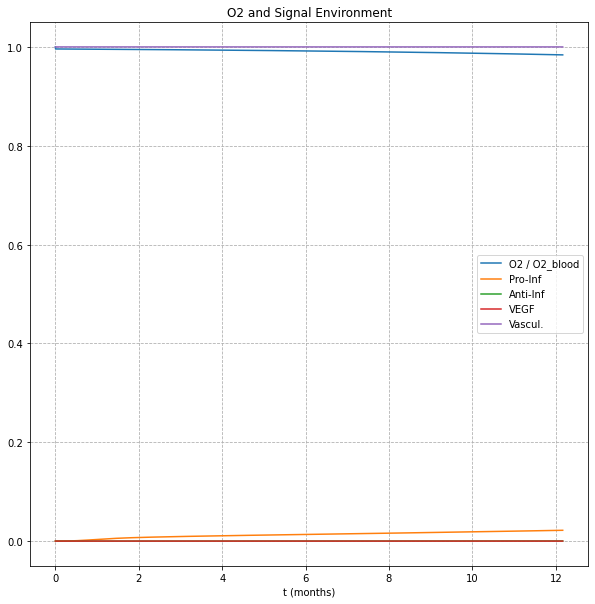

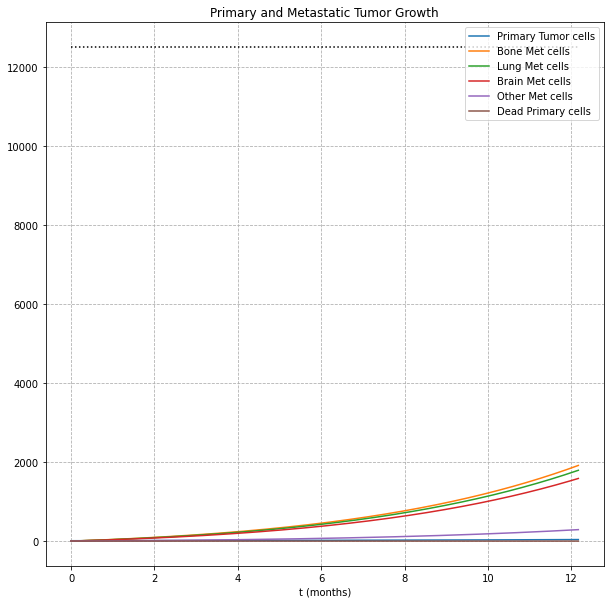

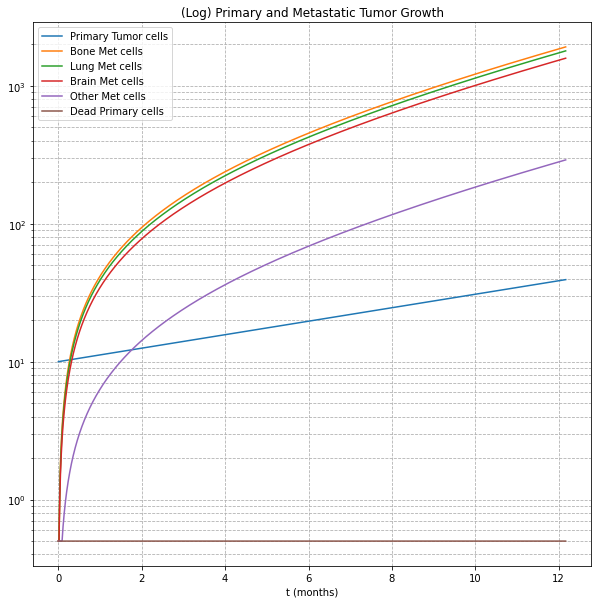

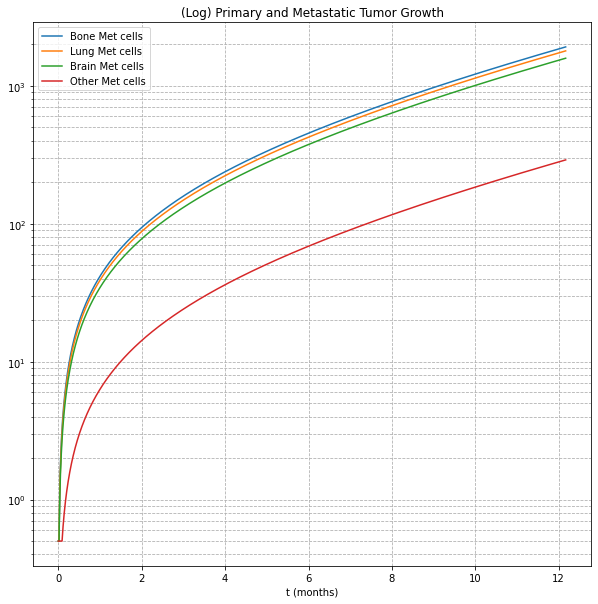

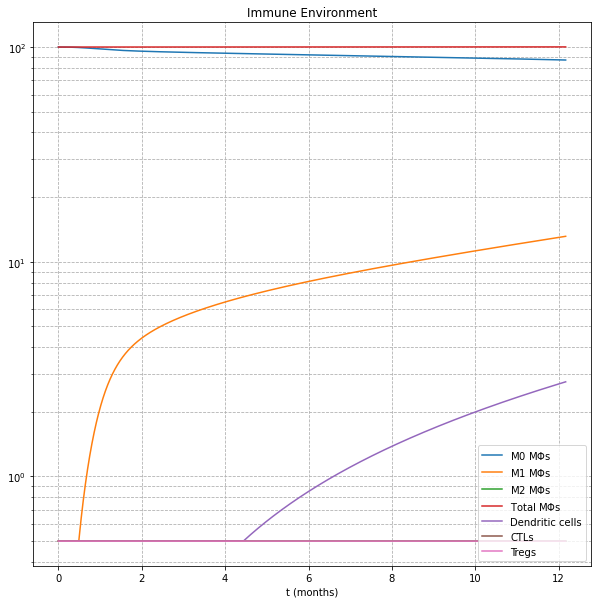

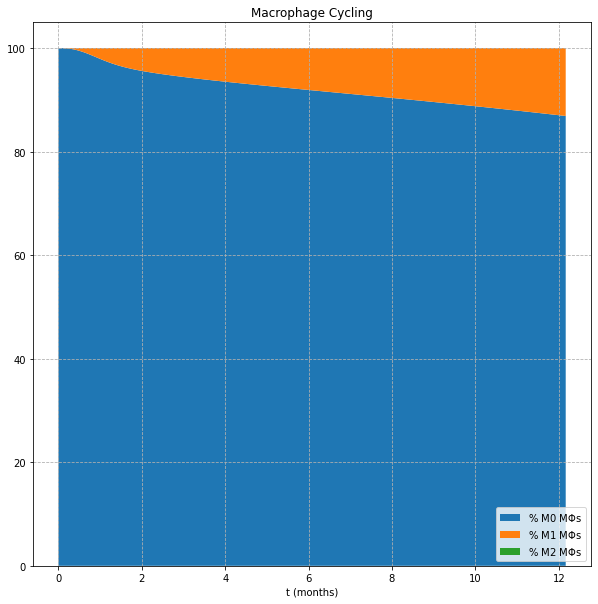

In [77]:
Sim = Simulation( 24*365*1, 0.5 ); 
Sim.run_model() 
plot( Sim , 'NSC' );  